# Fitting Tutorial

Below is a basic exercise in fitting a quadratic polynomial to some noisy data, done using many different fitting packages to demonstrate their basic usage.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The True Model (and Data Generation)

In [19]:
def model(x, a, b, c):
    '''The model we are fitting.'''
    return a*x**2 + b*x + c

x = np.linspace(-5, 5, 256)
SIG_N = 1
prms_true = (1.1, 2.2, 3.3)
y_meas = model(x, *prms_true) + SIG_N * np.random.normal(size=x.shape)

In [20]:
def report(prms):
    '''Generate a pretty report and plot for a set of parameters.'''
    if type(prms) == dict:
        prms = (prms['a'], prms['b'], prms['c'])
    if type(prms[0]) != float:
        prms = tuple(float(p) for p in prms)
    y = model(x, *prms)
    chisq = np.sum(np.abs(y_meas - y)**2 / SIG_N**2)
    chisq_r = chisq / (y_meas.size - len(prms))
    print(f'A:{prms[0]:7.3}, B:{prms[1]:7.3}, C:{prms[2]:7.3}')
    print(f'Chi-sq: {chisq:7.3}, Reduced Chi-sq: {chisq_r:7.3}')

    plt.figure()
    plt.plot(x, y_meas, '.', label='measured')
    plt.plot(x, y, label='model')
    plt.plot(x, y_meas - y, label='residual')
    plt.grid()
    _ = plt.legend()

A:    1.1, B:    2.2, C:    3.3
Chi-sq: 2.34e+02, Reduced Chi-sq:   0.926


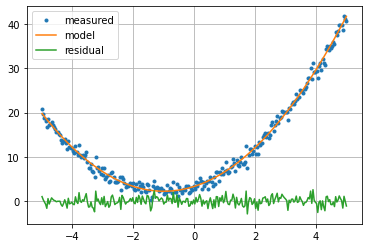

In [21]:
report(prms_true)

## <tt>numpy.linalg.lstsq</tt>

A=    1.1, B=   2.24, C=   3.39
Chi-sq: 2.81e+02, Reduced Chi-sq:    1.11


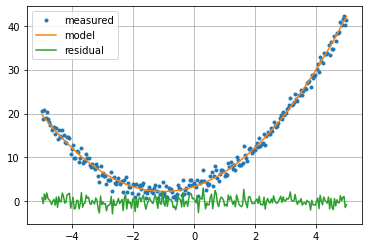

In [7]:
# np.linalg.lstsq
# generic matrix-based linear chi-sq optimizer
A = np.array([x**2, x, np.ones_like(x)]).T  # design matrix
prms_opt, res2, rank, s = np.linalg.lstsq(A, y_meas, rcond=None)
report(prms_opt)

## <tt>numpy.polyfit</tt>

A=    1.1, B=   2.24, C=   3.39
Chi-sq: 2.81e+02, Reduced Chi-sq:    1.11


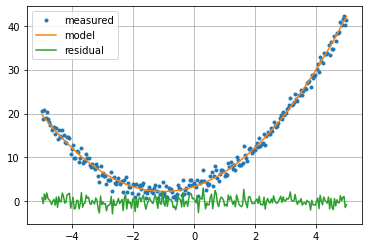

In [8]:
# np.polyfit
# special case of matrix-based linear chi-sq optimizer for polynomials
prms_opt = np.polyfit(x, y_meas, deg=2)
report(prms_opt)

##  <tt>scipy.optimize.fmin</tt>

Optimization terminated successfully.
         Current function value: 274.631497
         Iterations: 130
         Function evaluations: 234
A:    1.1, B:   2.21, C:   3.08
Chi-sq: 2.75e+02, Reduced Chi-sq:    1.09


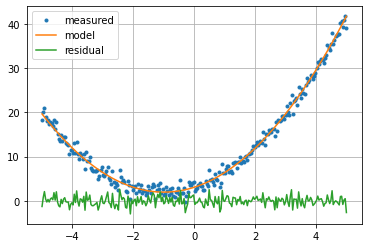

In [17]:
from scipy.optimize import fmin
def my_chisq(prms, x, y_meas, sig_n=1):
    return np.sum(np.abs(model(x, *prms) - y_meas)**2 / sig_n**2)

# scipy.optimize.fmin
# very generic function optimization, guesses gradient from serial function evaluations
init_guess = np.array([0.1, 0.1, 0.1])
prms_opt, chisq_min, niter, ncalls, flags = fmin(my_chisq, init_guess, (x, y_meas, SIG_N), full_output=True)
report(prms_opt)

## <tt>scipy.optimize.curve_fit</tt>

A=    1.1, B=   2.24, C=   3.39
Chi-sq: 2.81e+02, Reduced Chi-sq:    1.11


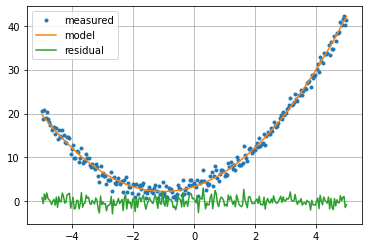

In [6]:
# scipy.optimize.curve_fit
from scipy.optimize import curve_fit
# generic function optimization via least-squares, guesses gradient from serial function evaluations
init_guess = np.array([0.1, 0.1, 0.1])
prms_opt, cov, info, msg, flag = curve_fit(model, x, y_meas, init_guess, SIG_N * np.ones_like(y_meas), full_output=True)
report(prms_opt)

## <tt>linsolve</tt>

A=    1.1, B=   2.24, C=   3.39
Chi-sq: 2.81e+02, Reduced Chi-sq:    1.11


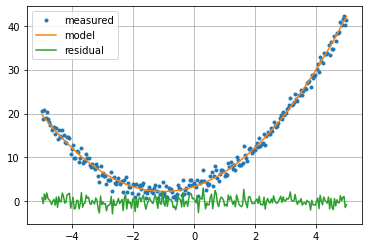

In [9]:
# linsolve interface to np.linalg.lstsq
import linsolve
data = {f'a*{xi**2}+b*{xi}+c': yi for xi, yi in zip(x, y_meas)}
ls = linsolve.LinearSolver(data)
prms_opt = ls.solve()
report(prms_opt)

## <tt>jax</tt> (and <tt>optax</tt>)

Note that (for now) <tt>optax</tt> does not support complex numbers (it fails silently), so build complex numbers inside jax from real-valued optax parameters.

In [10]:
import jax
import jax.numpy as jnp
import optax

In [11]:
def sim(prms, args):
    x, _, _ = args
    return prms['a'] * x**2 + prms['b'] * x + prms['c']

@jax.jit
def calc_loss(prms, args):
    _, y_meas, sig_n = args
    loss = jnp.sum(jnp.abs(y_meas - sim(prms, args))**2 / sig_n**2)
    return loss

def fit(optimizer, prms, args, maxiter=150, print_every=100, target_loss=1):
    opt_state = optimizer.init(prms)
    
    def step(opt_state, prms, args):
        loss, grads = jax.value_and_grad(calc_loss)(prms, args)
        updates, opt_state = optimizer.update(grads, opt_state, prms)
        prms = optax.apply_updates(prms, updates)
        return prms, opt_state, loss, grads
    
    for i in range(maxiter):
        prms, opt_state, loss, grads = step(opt_state, prms, args)
        if i % print_every == 0 or i == maxiter-1 or loss < target_loss:
            print(f'step {i:04d}, loss: {loss:9.7f}')
        if loss < target_loss:
            break
    return prms, loss, grads

step 0000, loss: 6376.7915039
step 0100, loss: 334.9360962
step 0200, loss: 292.1525879
step 0249, loss: 283.2296753
A=   1.11, B=   2.24, C=   3.35
Chi-sq: 2.85e+02, Reduced Chi-sq:    1.12


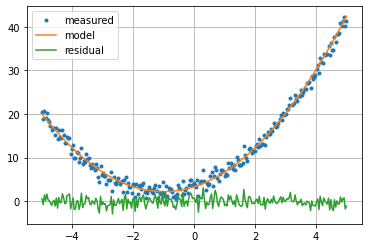

In [12]:
prms = {'a': jnp.asarray([1.0]), 'b': jnp.asarray([1.0]), 'c': jnp.asarray([1.0])}
optimizer = optax.lamb(learning_rate=1e-2)
prms_opt, chisq_min, _ = fit(optimizer, prms, (x, y_meas, SIG_N), maxiter=250, target_loss=y_meas.size-len(prms))
report(prms_opt)

In [ ]:
class Uniform:
    def __init__(self, name, lower, upper):
        self.name = name
        self.lower = lower
        self.upper = upper
    def start_val(self):
        return np.random.uniform(self.lower, self.upper)
    def log_prior(self, val):
        if self.lower < val < self.upper:
            return 0.0
        else:
            return -np.inf
        
class Normal:
    def __init__(self, name, mean, sigma):
        self.name = name
        self.mean = mean
        self.sigma = sigma
    def start_val(self):
        return self.mean + self.sigma * np.random.normal()
    def log_prior(self, val):
        return -0.5*(np.log(2 * np.pi * self.sigma**2) + np.abs(val - self.mean)**2 / self.sigma**2 )
        
        
prms = {
    'dly': Uniform('dly', lower=-50e-9, upper=-10e-9),
    'amp': Uniform('amp', lower=0.1, upper=1),
    #'bew': Uniform('bew', lower=best_ew-0.2, upper=best_ew+0.2),
    'bew': Normal('bew', mean=best_ew, sigma=0.01),
    'bns': Uniform('bns', lower=1, upper=2),
    #'bns': Normal('bns', mean=best_ns, sigma=0.017),
    #'rsn': Uniform('rsn', lower=0.001, upper=0.006),
    #'rsne': Uniform('rsne', lower=0.001, upper=0.006),
    #'rsnn': Uniform('rsnn', lower=0.001, upper=0.006),
    'logsig': Uniform('logsig', lower=-1.0, upper=-0.7),
}
prm_order = list(sorted(prms.keys()))
nprms = len(prm_order)
        
def log_prior(**kwargs):
    return sum([prms[k].log_prior(v) for k, v in kwargs.items()])

def log_likelihood(y, yhat, sig_noise):
    L = -0.5 * (np.log(2 * np.pi * sig_noise**2) + np.abs(y - yhat)**2 / sig_noise**2 )
    return np.sum(L)

def log_probability(prms, lsts, freqs, y):
    logsig = prms[-1]
    prms = dict(zip(prm_order, prms))
    lp = log_prior(**prms)
    if not np.isfinite(lp):
        return -np.inf
    yhat = full_sim(lsts, freqs, **prms)
    return lp + log_likelihood(y, yhat, 10**logsig)

nwalkers = nprms * 4
sol0 = np.array([[prms[k].start_val() for _ in range(nwalkers)] for k in prm_order]).T

CH0, CH1 = 20, 45
CDEC = 4
#T0, T1 = 8000, 23000
T0, T1 = 3000, 7000
#T0, T1 = 0, -1
TDEC = 2
sampler = emcee.EnsembleSampler(nwalkers, nprms, log_probability,
                                args=(lsts[T0:T1:TDEC], freqs[CH0:CH1:CDEC], data_cal[T0:T1:TDEC,CH0:CH1:CDEC]))
sampler.run_mcmc(sol0, 5000, progress=True);

In [ ]:
trace = sampler.get_chain(discard=1200, thin=5)
trace = dict(zip(prm_order, trace.T))
if PLOT:
    fig, axes = plt.subplots(nrows=nprms, sharex=True, figsize=(8,8))
    for i, k in enumerate(prm_order):
        axes[i].plot(trace[k].T)
        axes[i].set_ylabel(k)
    axes[nprms-1].set_xlabel('Step')